# **TR_2021/06 - Technical report: Mann Whitney U test for cardiovascular hospitalizations and extreme climatic events**


|Technical Report ID  |2021/06|
|--|--|
| Title |Mann Whitney U test for cardiovascular hospitalizations and extreme climatic events|
| Authors | Júlia De Lázari, Paula Dornhofer|
| Creation Date| 2021-03|

## Databases description

**inputs:** 

- hospitalizações_circulatório.csv: Dataframe of hospitalizations due to cardiovascular ICDs from 2014 to 2018.

- EV_temperature.csv, EV_pressure.csv, EV_humidity.csv: Dataframes with the extreme events computed. Viracopos data was used for this.

## Analysis 

This report presents an analysis of the the Mann Whitney U test for the [extreme climate events](https://github.com/climate-and-health-datasci-Unicamp/project-climatic-variations-cardiovascular-diseases/blob/main/notebooks/TR_03_2020_Extreme_climatic_events_for_Campinas.ipynb) and hospitalizations due to cardiovascular ICDs.


##**Mann Whitney U**

Mann Whitney U is a non-parametric test that compares two distributions. Its null hypothesis is that there is no difference between the analysed distributions [MacFarland e Yates 2016].

A two-sided test was used and a level of 5% of significance was chosen.

The test was applied to test the distributions of hospitalizations in days under influence of an extreme event and control days (without the event). Distributions were compared on the day of the event and for lags up to 10.  If the event occured at 01/01/2018, 02/01/2018 is considered lag1, 03/01/2018 lag2 and so on. The test was applied for the total data and also for stratitifications (sex, age, age and sex).



##**Import libraries**

In [ ]:
#-------------------------------------------------------------------#
#                       Import libraries                            #
#-------------------------------------------------------------------#
import pandas as pd
import numpy as np
import datetime
import more_itertools as mit
import datetime
import statistics as stat
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import scipy
import math
import seaborn as sns
import pylab
from datetime import timedelta
from calendar import isleap
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

pd.options.mode.chained_assignment = None

Mounted at /content/drive


In [ ]:
#import py file with funtions from drive
import sys
import os

py_file_location = '/content/drive/Shareddrives/Clima&Saúde/Pesquisadores/DeLázari_Júlia/notebooks/Climatex/'
sys.path.append(os.path.abspath(py_file_location))
import climatex as tex

## **Load and merge dataframes**

In [ ]:
#-------------------------------------------------------------------#
#                      cardiovascular hospitalizations              #
#-------------------------------------------------------------------#

df_hosp = pd.read_csv('/content/drive/Shared drives/Clima&Saúde/Dados/Dados_Saude/Hospitalizacoes_SSC/data/processed/hospitalizações_circulatório.csv')
df_hosp = df_hosp.drop(columns = {'Unnamed: 0','Hora','Número Paciente','Descrição CID'}) #drop unneeded columns
df_hosp = df_hosp.rename(columns = {'Data':'DATE','Idade': 'IDADE','Sexo': 'SEXO'}) #rename Data to DATE to merge dataframes
df_hosp = df_hosp[(df_hosp.DATE !='2012-02-29')&(df_hosp.DATE !='2016-02-29')] #remove leap year dates (02-29)
df_hosp = df_hosp.sort_values('DATE')

In [ ]:
#-------------------------------------------------------------------#
#                  Extreme climatic variations                      #
#-------------------------------------------------------------------#
df_temp =  pd.read_csv('/content/drive/Shared drives/Clima&Saúde/Pesquisadores/DeLázari_Júlia/data/Climáticos_Viracopos/EV_temperature.csv')
df_temp = df_temp.drop(columns = {'Unnamed: 0','DAY365'})
df_temp = df_temp[df_temp['DATE']>'2014-01-01']

df_humidity =  pd.read_csv('/content/drive/Shared drives/Clima&Saúde/Pesquisadores/DeLázari_Júlia/data/Climáticos_Viracopos/EV_humidity.csv')
df_humidity = df_humidity.drop(columns = {'Unnamed: 0','DAY365'})
df_humidity = df_humidity[df_humidity['DATE']>'2014-01-01']

df_pressure =  pd.read_csv('/content/drive/Shared drives/Clima&Saúde/Pesquisadores/DeLázari_Júlia/data/Climáticos_Viracopos/EV_pressure.csv')
df_pressure = df_pressure.drop(columns = {'Unnamed: 0','DAY365'})
df_pressure = df_pressure[df_pressure['DATE']>'2014-01-01']

In [ ]:
#-------------------------------------------------------------------#
#              Merge health and climate dataframes                  #
#-------------------------------------------------------------------#

df_temp = pd.merge(df_temp,df_hosp, on='DATE', how='outer')

df_humidity = pd.merge(df_humidity,df_hosp, on='DATE', how='outer')

df_pressure = pd.merge(df_pressure,df_hosp, on='DATE', how='outer')

##**Test normality of data**

QQ-plots and the Shapiro-Wilk test were used to check normality of data. The Shapiro test null hypothesis is a normal distribution. Based on the result of the test, this hyposthis was rejected.


In [ ]:
# Function to compute Shapiro Wilk test
def get_shapiro(database):
  #column for number of hospitalizations
  database['N_hosp'] = np.where(database['CID'].isnull(),0,database.groupby(['DATE']).DATE.transform('count'))
  database = database.drop_duplicates('DATE',keep='first')
  
  #qqplot
  scipy.stats.probplot(database['N_hosp'], dist="norm", plot=pylab)
  pylab.title('Daily number of hospitalizations due to cardiovascular diseases \n Normal distribution: theoretical vs observed',fontsize = 15)
  pylab.show()

  #Shapiro Wilk test
  from scipy.stats import shapiro
  print('Shapiro Wilk test')
  alpha = 0.01
  tes,p2 = shapiro(database['N_obitos'])
  print("W statistic:",tes)
  print("p value:",p2)
  if p2 > alpha:
	  print('Sample looks Gaussian (fail to reject H0)\n')
  else:
	  print('Sample does not look Gaussian (reject H0)\n')

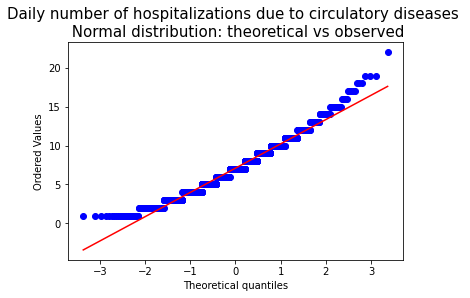

Shapiro Wilk test
W statistic: 0.9738879203796387
p value: 1.1073735693946461e-17
Sample does not look Gaussian (reject H0)



In [ ]:
get_shapiro(df_hosp)

## **Functions**

Automatize some repeated operations along the notebook
- stratify functions: different stratifications of the dataframe
- get_mann_whitney_lag: get the result of the Mann Whitney U test (event vs control) for lags from 0 to 10


###**Stratify functions**

In [ ]:
#@title Stratify age sex
def stratify_age_sex(database): 
    between_20_65_F = database[(database['IDADE'] >= 20) & (database['IDADE'] < 65)  & (database['SEXO']=="F")]
    between_20_65_M = database[(database['IDADE'] >= 20) & (database['IDADE'] < 65) & (database['SEXO']=="M")]   
    over_65_F = database[(database['IDADE'] > 64) & (database['SEXO']=="F")]   
    over_65_M = database[(database['IDADE'] > 64) & (database['SEXO']=="M")]     

    dataframes = [database, between_20_65_F, between_20_65_M,over_65_F,over_65_M]
    df_names = ["Todas idades","Mulheres entre 20 e 65 anos","Homens entre 20 e 65 anos","Mulheres acima de 65 anos","Homens acima de 65 anos"]

    return dataframes, df_names

In [ ]:
#@title Stratify age
def stratify_age(database):
  #less_20 = database[(database['IDADE'] < 20)]  
  between_20_40 = database[(database['IDADE'] >= 20) & (database['IDADE'] < 40)]
  between_40_65 = database[(database['IDADE'] >= 40) & (database['IDADE'] < 65)]   
  over_65 = database[(database['IDADE'] > 64)]   
  over_75 = database[(database['IDADE'] > 75)]

  dataframes  = [database, between_20_40, between_40_65, over_65, over_75] 
  df_names = ["Todas idades", "Entre 20 e 40 anos","Entre 40 e 65 anos","Acima de 65 anos","Acima de 75 anos"]

  return dataframes, df_names

In [ ]:
#@title Stratify sex
def stratify_sex(database):
  women = database[database['SEXO']=='F']
  men = database[database['SEXO']=='M']

  dataframes = [database, women, men]
  df_names = ["Todos", "Mulheres", "Homens"]

  return dataframes, df_names

###**Plot functions**

In [ ]:
#@title Boxplot
def get_boxplot(df_control,df_event,title,outcome):

  plt.figure(figsize=(6,4))
  plt.grid()
  plt.title(f'Control and Event Vectors Boxplot \n {title}')
  plt.ylabel('Number of Deaths')
  data = [df_control[f'N_{outcome}'], df_event[f'N_{outcome}']]
  labels = ['Control', 'Event']
  plt.boxplot(data, labels=labels)
  plt.show()

In [ ]:
#@title Distribution
def get_dist(database,control,event,title, outcome):  
  df_control = control
  df_event = event

  n_event = pd.DataFrame(df_event[f'N_{outcome}'].value_counts())
  n_event = n_event.reset_index()
  n_event['Percent_event'] = n_event[f'N_{outcome}']/n_event[f'N_{outcome}'].sum()*100
  n_event['Percent_event'] = round(n_event['Percent_event'],2)
  n_event = n_event.rename(columns={'index':f'N_{outcome}',f'N_{outcome}':'Count_event'})
  n_event = n_event.sort_values('Percent_event', ascending = False)

  n_control = pd.DataFrame(df_control[f'N_{outcome}'].value_counts())
  n_control = n_control.reset_index()
  n_control['Percent_control'] = n_control[f'N_{outcome}']/n_control[f'N_{outcome}'].sum()*100
  n_control['Percent_control'] = round(n_control['Percent_control'],2)
  n_control = n_control.rename(columns={'index':f'N_{outcome}',f'N_{outcome}':'Count_control'})
  n_control = n_control.sort_values('Percent_control', ascending = False)
    
    #merge into one dataframe
  from functools import reduce
  n_outcome = reduce(lambda x,y: pd.merge(x,y, on=f'N_{outcome}', how='outer'), [n_total,n_event,n_control])
  n_outcome = n_outcome.sort_values(f'N_{outcome}')

  #plot
  plt.figure(figsize=(8,4))

  plt.plot(n_outcome[f'N_{outcome}'], n_outcome['Percent_event'], label = 'event')
  plt.plot(n_outcome[f'N_{outcome}'], n_outcome['Percent_control'], label = 'control')
  plt.xlabel(f'Number of {outcome}')
  plt.ylabel('Frequency (%)',fontsize = 15)
  plt.ylim(0,max(n_outcome['Percent_event'].max(),n_outcome['Percent_control'].max())+5)
  plt.title(f'Frequency of number of {outcome} \n {title}',fontsize = 20)
  plt.legend()
  plt.show()

###**Mann Whitney function**

In [ ]:
def get_mann_whitney_lag(database,event,stratify,test='two-sided',plot=None):
  from scipy.stats import mannwhitneyu

  #aux lists
  u_stat = []
  p = [] 
  sig = []
  mean_event = []
  median_event = []
  mean_control = []
  median_control = []
  lag_list = []
  subsets_list = []

  #subsets depending on the stratification
  if (stratify == 'age and sex'): 
    dataframes, df_names = stratify_age_sex(database)
  elif (stratify == 'sex'): 
    dataframes, df_names = stratify_sex(database)
  elif (stratify == 'age'): 
    dataframes, df_names = stratify_age(database)
  elif (stratify == 'race'):
    dataframes, df_names = stratify_race(database)

  #aux variable 
  j = 0
  for df in dataframes: #mann whitney for each subset
    #column for number of deaths
    df['N_hosp'] = np.where(df['CID'].isnull(),0,df.groupby(['DATE']).DATE.transform('count'))
    df = df.drop_duplicates('DATE',keep='first')
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['YEAR'] = df['DATE'].dt.year
    df = tex.complete_df(df)
    df['N_hosp'].fillna(0,inplace=True)

    for lag in range(0,11):
      
      #subset for extreme event
      df[f'{event}_lag_{lag}'] = df[f'{event}'].shift(lag)
      df_event = df[df[f'{event}_lag_{lag}']==1]
      
      #subset for control
      df_control = df[df[f'{event}_lag_{lag}']==0]
    
      #get mean and median for event and control
      mean_event.append(round(stat.mean(df_event['N_hosp']),2))
      mean_control.append(round(stat.mean(df_control['N_hosp']),2))

      # mann whitney u test
      u_statistic, p_value = mannwhitneyu(df_event['N_hosp'], df_control['N_hosp'], alternative = test)
      p_sig = np.where(p_value<0.05,'*','-') #mark if p is significant
      u_stat.append(u_statistic)
      p.append(round(p_value,3))
      sig.append(p_sig)
      lag_list.append(lag)
      subsets_list.append(df_names[j])

      if p_value < 0.05:
        if (plot=='boxplot'):
          get_boxplot(df_control,df_event,df_names[j]+'lag'+str(lag), outcome)
        if (plot=='dist'):
          get_dist(database,df_control,df_event,df_names[j]+'lag'+str(lag), outcome)
      
    j += 1 #increment variable

  table = pd.DataFrame() #create a table
  table['Group'] = subsets_list
  table['Lag'] = lag_list
  table['U Statistic'] = u_stat
  table['P'] = p
  table['Significance'] = sig
  table['Mean event'] = mean_event
  table['Mean control'] = mean_control
  table = table[table['Significance']=='*']
  del table['Significance']

  return table

## **Temperature**

###**Extreme thermal range**

####**Sex**

In [ ]:
get_mann_whitney_lag(df_temp,'above_pct_range','sex')

,Group,Lag,U Statistic,P,Mean event,Mean control
4,Todos,4,82586.0,0.044,6.49,7.11
26,Homens,4,73704.0,0.011,3.48,3.94


####**Age**

In [ ]:
get_mann_whitney_lag(df_temp,'above_pct_range','age')

,Group,Lag,U Statistic,P,Mean event,Mean control
4,Todas idades,4,82586.0,0.044,6.49,7.11
36,Acima de 65 anos,3,78480.0,0.043,3.24,3.64


####**Age and sex**

In [ ]:
get_mann_whitney_lag(df_temp,'above_pct_range','age and sex')

,Group,Lag,U Statistic,P,Mean event,Mean control
4,Todas idades,4,82586.0,0.044,6.49,7.11
17,Mulheres entre 20 e 65 anos,6,41653.5,0.007,1.05,1.42
36,Mulheres acima de 65 anos,3,53501.5,0.010,1.44,1.80
48,Homens acima de 65 anos,4,55444.5,0.032,1.54,1.87


###**Extreme temperature difference between days**

####**Sex**

In [ ]:
get_mann_whitney_lag(df_temp,'above_pct_dif','sex')

,Group,Lag,U Statistic,P,Mean event,Mean control
18,Mulheres,7,23016.5,0.016,4.24,3.15


####**Age**

In [ ]:
get_mann_whitney_lag(df_temp,'above_pct_dif','age')

,Group,Lag,U Statistic,P,Mean event,Mean control
54,Acima de 75 anos,10,8934.5,0.024,1.0,1.62


####**Age and sex**

In [ ]:
get_mann_whitney_lag(df_temp,'above_pct_dif','age and sex')

,Group,Lag,U Statistic,P,Mean event,Mean control
18,Mulheres entre 20 e 65 anos,7,15252.5,0.032,2.11,1.39
36,Mulheres acima de 65 anos,3,10913.5,0.043,1.20,1.79
49,Homens acima de 65 anos,5,9768.0,0.042,1.17,1.87


##**Pressure**

###**Low pressure waves**

####**Sex**

In [ ]:
get_mann_whitney_lag(df_pressure,'LPW','sex')

,Group,Lag,U Statistic,P,Mean event,Mean control
9,Todos,9,30265.0,0.037,6.12,7.09
14,Mulheres,3,41520.0,0.037,3.60,3.14
22,Homens,0,40394.0,0.033,4.72,4.02
31,Homens,9,26281.5,0.019,3.18,3.94


####**Age**

In [ ]:
get_mann_whitney_lag(df_pressure,'LPW','age')

,Group,Lag,U Statistic,P,Mean event,Mean control
9,Todas idades,9,30265.0,0.037,6.12,7.09
31,Entre 40 e 65 anos,9,25518.5,0.005,2.27,3.09
33,Acima de 65 anos,0,40499.5,0.045,4.38,3.73
44,Acima de 75 anos,0,30904.0,0.016,2.39,2.01
46,Acima de 75 anos,2,30967.5,0.017,2.08,1.59
47,Acima de 75 anos,3,30935.5,0.018,2.08,1.59


####**Age and sex**

In [ ]:
get_mann_whitney_lag(df_pressure,'LPW','age and sex')

,Group,Lag,U Statistic,P,Mean event,Mean control
9,Todas idades,9,30265.0,0.037,6.12,7.09
11,Mulheres entre 20 e 65 anos,0,15203.0,0.010,1.42,1.88
18,Mulheres entre 20 e 65 anos,7,16094.0,0.042,0.94,1.41
31,Homens entre 20 e 65 anos,9,22624.0,0.023,1.55,2.09
33,Mulheres acima de 65 anos,0,31266.0,0.015,2.69,2.14
51,Homens acima de 65 anos,7,21416.5,0.045,1.42,1.88


###**High pressure waves**

####**Sex**

In [ ]:
get_mann_whitney_lag(df_pressure,'HPW','sex')

,Group,Lag,U Statistic,P,Mean event,Mean control


####**Age**

In [ ]:
get_mann_whitney_lag(df_pressure,'HPW','age')

,Group,Lag,U Statistic,P,Mean event,Mean control


####**Age and sex**

In [ ]:
get_mann_whitney_lag(df_pressure,'HPW','age and sex')

,Group,Lag,U Statistic,P,Mean event,Mean control


###**Extreme pressure difference between days**

####**Sex**

In [ ]:
get_mann_whitney_lag(df_pressure,'above_pct_dif', 'sex')

,Group,Lag,U Statistic,P,Mean event,Mean control


####**Age**

In [ ]:
get_mann_whitney_lag(df_pressure,'above_pct_dif','age')

,Group,Lag,U Statistic,P,Mean event,Mean control
54,Acima de 75 anos,10,82079.5,0.042,1.43,1.63


####**Age and sex**

In [ ]:
get_mann_whitney_lag(df_pressure,'above_pct_dif', 'age and sex')

,Group,Lag,U Statistic,P,Mean event,Mean control
13,Mulheres entre 20 e 65 anos,2,70557.0,0.005,1.13,1.38


##**Humidity**

###**Low humidity waves**

####**Sex**

In [ ]:
get_mann_whitney_lag(df_humidity,'LHW', 'sex')

,Group,Lag,U Statistic,P,Mean event,Mean control
0,Todos,0,92891.5,0.009,6.41,7.12
1,Todos,1,90898.0,0.003,6.39,7.12
3,Todos,3,93395.5,0.013,6.39,7.12
4,Todos,4,94405.0,0.021,6.48,7.11
5,Todos,5,94327.5,0.021,6.50,7.11
6,Todos,6,94060.0,0.019,6.49,7.12
7,Todos,7,93930.0,0.018,6.41,7.13
22,Homens,0,88587.5,0.038,3.64,4.07
23,Homens,1,86798.5,0.017,3.50,3.96
24,Homens,2,88580.0,0.040,3.52,3.93


####**Age**

In [ ]:
get_mann_whitney_lag(df_humidity,'LHW','age')

,Group,Lag,U Statistic,P,Mean event,Mean control
0,Todas idades,0,92891.5,0.009,6.41,7.12
1,Todas idades,1,90898.0,0.003,6.39,7.12
3,Todas idades,3,93395.5,0.013,6.39,7.12
4,Todas idades,4,94405.0,0.021,6.48,7.11
5,Todas idades,5,94327.5,0.021,6.50,7.11
6,Todas idades,6,94060.0,0.019,6.49,7.12
7,Todas idades,7,93930.0,0.018,6.41,7.13
23,Entre 40 e 65 anos,1,78254.5,0.009,2.68,3.15
25,Entre 40 e 65 anos,3,76843.0,0.004,2.61,3.15
26,Entre 40 e 65 anos,4,80990.5,0.040,2.75,3.12


####**Age and sex**

In [ ]:
get_mann_whitney_lag(df_humidity,'LHW', 'age and sex')

,Group,Lag,U Statistic,P,Mean event,Mean control
0,Todas idades,0,92891.5,0.009,6.41,7.12
1,Todas idades,1,90898.0,0.003,6.39,7.12
3,Todas idades,3,93395.5,0.013,6.39,7.12
4,Todas idades,4,94405.0,0.021,6.48,7.11
5,Todas idades,5,94327.5,0.021,6.50,7.11
6,Todas idades,6,94060.0,0.019,6.49,7.12
7,Todas idades,7,93930.0,0.018,6.41,7.13
11,Mulheres entre 20 e 65 anos,0,50493.0,0.035,1.70,1.88
12,Mulheres entre 20 e 65 anos,1,50016.0,0.030,1.13,1.43
47,Homens acima de 65 anos,3,62504.0,0.037,1.54,1.88


###**High humidity waves**

####**Sex**

In [ ]:
get_mann_whitney_lag(df_humidity,'HHW', 'sex')

,Group,Lag,U Statistic,P,Mean event,Mean control


####**Age**

In [ ]:
get_mann_whitney_lag(df_humidity,'HHW','age')

,Group,Lag,U Statistic,P,Mean event,Mean control
22,Entre 40 e 65 anos,0,2081.5,0.043,1.8,3.28
34,Acima de 65 anos,1,7170.0,0.012,5.8,3.63
40,Acima de 65 anos,7,7089.5,0.014,6.4,3.62
45,Acima de 75 anos,1,5869.0,0.011,3.2,1.61
46,Acima de 75 anos,2,5468.5,0.037,3.0,1.60


####**Age and sex**

In [ ]:
get_mann_whitney_lag(df_humidity,'HHW', 'age and sex')

,Group,Lag,U Statistic,P,Mean event,Mean control
33,Mulheres acima de 65 anos,0,4836.5,0.023,3.5,2.15
42,Mulheres acima de 65 anos,9,4942.5,0.017,4.0,1.78
51,Homens acima de 65 anos,7,5614.0,0.049,3.2,1.86


###**Extreme humidity variation**

####**Sex**

In [ ]:
get_mann_whitney_lag(df_humidity,'above_pct_range','sex')

,Group,Lag,U Statistic,P,Mean event,Mean control
4,Todos,4,152641.0,0.035,6.66,7.12
10,Todos,10,150953.0,0.023,6.66,7.13
20,Mulheres,9,130488.5,0.016,2.83,3.20
26,Homens,4,141657.0,0.016,3.55,3.96
28,Homens,6,142916.0,0.029,3.61,3.99
32,Homens,10,142755.0,0.030,3.61,3.96


####**Age**

In [ ]:
get_mann_whitney_lag(df_humidity, 'above_pct_range','age')

,Group,Lag,U Statistic,P,Mean event,Mean control
4,Todas idades,4,152641.0,0.035,6.66,7.12
10,Todas idades,10,150953.0,0.023,6.66,7.13
28,Entre 40 e 65 anos,6,132566.0,0.019,2.81,3.14
41,Acima de 65 anos,8,138824.5,0.018,3.33,3.64
43,Acima de 65 anos,10,135713.0,0.005,3.27,3.67
52,Acima de 75 anos,8,91425.0,0.024,1.41,1.62


####**Age and sex**

In [ ]:
get_mann_whitney_lag(df_humidity,'above_pct_range', 'age and sex')

,Group,Lag,U Statistic,P,Mean event,Mean control
4,Todas idades,4,152641.0,0.035,6.66,7.12
10,Todas idades,10,150953.0,0.023,6.66,7.13
20,Mulheres entre 20 e 65 anos,9,77891.0,0.033,1.20,1.42
27,Homens entre 20 e 65 anos,5,109532.0,0.007,1.79,2.10
52,Homens acima de 65 anos,8,104564.0,0.026,1.64,1.88
54,Homens acima de 65 anos,10,100827.5,0.003,1.55,1.90


###**Extreme humidity difference between days**

####**Sex**

In [ ]:
get_mann_whitney_lag(df_humidity,'above_pct_dif','sex')

,Group,Lag,U Statistic,P,Mean event,Mean control
27,Homens,5,10729.5,0.047,2.82,3.92


####**Age**

In [ ]:
get_mann_whitney_lag(df_humidity,'above_pct_dif','age')

,Group,Lag,U Statistic,P,Mean event,Mean control
47,Acima de 75 anos,3,9585.0,0.025,0.95,1.61


####**Age and sex**

In [ ]:
get_mann_whitney_lag(df_humidity,'above_pct_dif', 'age and sex')

,Group,Lag,U Statistic,P,Mean event,Mean control
14,Mulheres entre 20 e 65 anos,3,12870.5,0.010,2.07,1.36
18,Mulheres entre 20 e 65 anos,7,12176.5,0.036,2.07,1.39
33,Mulheres acima de 65 anos,0,15832.0,0.013,2.75,2.15


##**References**

MACFARLAND, T. W.; YATES, J. M. Mann–whitney u test. In:Introduction tononparametric statistics for the biological sciences using R. [S.l.]: Springer, 2016. p. 103–132.